# Assignment 2

## Initialization

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/Master_UdeM/IFT-6135_H2022/IFT6135_Programming/assignment2" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

ERROR: Invalid requirement: 'import warnings' (from line 1 of /content/assignment/requirements.txt)


### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from lstm_solution import LSTM
from utils.wikitext2 import Wikitext2
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs
from run_exp_lstm import train, evaluate


## Experiments

### LSTM

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularization, adding logs).

In [ ]:
@dataclass
class Arguments:
  # Data
  data_folder: str = '/content/assignment/data'
  batch_size: int = 16

  # Model
  model: str = 'lstm'  # [lstm, gpt1]
  embeddings: str = '/content/assignment/data/embeddings.npz'
  layers: int = 1

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 10
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 2
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 10

The 6 configurations you need to run in Problem 1. Be careful that there is no discrepency between the configurations defined in `run_exp_lstm.py` and the ones below. In case there is a difference, the version from `run_exp_lstm.py` should be considered the ones to run.

In [ ]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs = {
  1: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='lstm', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='lstm', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw')
}

In [ ]:
def main(args):
  # Seed the experiment, for repeatability
  seed_experiment(args.seed)

  # Dataloaders
  train_dataset = Wikitext2(args.data_folder, split="train")
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
  )

  valid_dataset = Wikitext2(args.data_folder, split="validation")
  valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  test_dataset = Wikitext2(args.data_folder, split="test")
  test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  # Download the embeddings
  if not os.path.isfile(args.embeddings):
    print("No embedding file please place embedding.pkl in ./data")

  # Model
  if args.model == "lstm":
    model = LSTM.load_embeddings_from(
      args.embeddings, hidden_size=512, num_layers=args.layers
    )
  else:
    raise ValueError("Unknown model {0}".format(args.model))
  model.to(args.device)

  # Optimizer
  if args.optimizer == "adamw":
    optimizer = optim.AdamW(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
  elif args.optimizer == "sgd":
    optimizer = optim.SGD(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "momentum":
    optimizer = optim.SGD(
      model.parameters(),
      lr=args.lr,
      momentum=args.momentum,
      weight_decay=args.weight_decay,
    )

  print(
    f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
    f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
  )

  train_losses, valid_losses = [], []
  train_ppls, valid_ppls = [], []
  train_times, valid_times = [], []
  for epoch in range(args.epochs):

    tqdm.write(f"====== Epoch {epoch} ======>")

    loss, ppl, wall_time = train(epoch, model, train_dataloader, optimizer, args)
    train_losses.append(loss)
    train_ppls.append(ppl)
    train_times.append(wall_time)

    loss, ppl, wall_time = evaluate(epoch, model, valid_dataloader, args)
    valid_losses.append(loss)
    valid_ppls.append(ppl)
    valid_times.append(wall_time)

  test_loss, test_ppl, test_time = evaluate(
    epoch, model, test_dataloader, args, mode="test"
  )

  print(f"===== Best validation perplexity: {min(valid_ppls):.3f} =====>")

  return (
    train_losses,
    train_ppls,
    train_times,
    valid_losses,
    valid_ppls,
    valid_times,
    test_loss,
    test_ppl,
    test_time,
  )

In [ ]:
args = configs[1]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Similarly you can add and run the configs listed in 'run_exps_vit.py' for the problem 3

### ViT

In [ ]:
@dataclass
class Arguments_vit:
  # Data
  data_folder: str = '/content/assignment/data'
  batch_size: int = 16

  # Model
  model: str = 'vit'  # [lstm, gpt1]
  embeddings: str = '/content/assignment/data/embeddings.npz'
  layers: int = 1

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 50
  # lr: float = 1e-3
  lr: float = 3e-4 
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 4
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 10

  # autre
  block: str = 'prenorm'

In [ ]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs_vit = {
  1: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='adam', exp_id="vit_exp2_1"),#10
  2: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='adamw', exp_id="vit_exp2_2"),
  3: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='sgd', exp_id="vit_exp2_3"),
  4: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='momentum', exp_id="vit_exp2_4"),

  5: Arguments_vit(model='vit', layers=4, batch_size=128, log=True, epochs=10, optimizer='adamw', exp_id="vit_exp2_5"),
  6: Arguments_vit(model='vit', layers=6, batch_size=128, log=True, epochs=10, optimizer='adamw', exp_id="vit_exp2_6"),
  7: Arguments_vit(model='vit', layers=6, batch_size=128, log=True, epochs=10, optimizer='adamw', block='postnorm' , exp_id="vit_exp2_7")

}

##### Train once to test

In [ ]:
from run_exp_vit import train, evaluate, main

args = configs_vit[1]  # Run the first configuration
logs =  main(args)
if args.log:
  save_logs(args, *logs)

In [ ]:
len(logs), type(logs)
#a,b,c,d,e,f,g,h,i = logs

(9, tuple)

`train_losses,
train_ppls,
train_times,
valid_losses,
valid_ppls,
valid_times,
test_loss,
test_ppl,
test_time,`

###### Displayed in the following order :
`        train_losses,
        train_accs,
        train_times,
        valid_losses,
        valid_accs,
        valid_times,
        test_loss,
        test_acc,
        test_time,
`

##### Plotting fctn

In [ ]:
import matplotlib
def plottingLossAcc_ViT(epochs,log, arg, configuration):
  train_losses, train_accs, train_times, valid_losses, valid_accs, valid_times, test_loss, test_acc, test_time = log
  fig, axes = plt.subplots(1,2, constrained_layout=True, sharey= False, figsize=(8,2), dpi=150)
  fig.suptitle("Config. n°: "+str(configuration)+" Optim: "+ arg.optimizer + " Batch_size: "+ str(arg.batch_size) + " Num_layers : " + str(arg.layers) + "block : "+ arg.block +  " Train time=%0.2f"%(sum(train_times))+" s")
  matplotlib.rcParams['legend.fontsize'] = 8
  axes[0].plot(epochs, train_losses , marker=',', label="train_loss=%0.3f"%min(train_losses),color='darkviolet')
  axes[0].plot(epochs, valid_losses , marker=',', label="valid_loss=%0.3f"%min(valid_losses),color='darkblue')
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[0].legend(loc="upper right")
  axes[1].plot(epochs, train_accs , marker=',', label="train_accs=%0.2f"%max(train_accs),color='darkviolet')
  axes[1].plot(epochs, valid_accs , marker=',', label="valid_accs=%0.2f"%max(valid_accs),color='darkblue')
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].legend(loc="lower right")
  filename= "vit_config_"+str(configuration)+".png"
  fig.savefig("/content/gdrive/MyDrive/Master_UdeM/IFT-6135_H2022/IFT6135_Programming/assignment2/figs/"+filename)

In [ ]:
from run_exp_vit import train, evaluate, main


args = []
logs = []
for c,i in zip(configs_vit,range(len(configs_vit))):
    args.append(configs_vit[c])
    epochs = args[i].epochs
    e = np.arange(args[i].epochs) +1 #numb of epochs
    logs.append(main(args[i]))
    if args[i].log:
        save_logs(args[i], *logs[i])
    plottingLossAcc_ViT(epochs=e,log=logs[i],arg=args[i],configuration=c)

In [ ]:
range(len(configs_vit))

range(0, 7)

In [ ]:
import pandas as pd
def create_df(log,arg):
  df = pd.DataFrame(columns={"Config","Block","Num Layers","Optimizer", "Train Acc.", "Valid Acc.", "Train Loss", "Valid Loss"})
  for i in range(len(arg)):
    train_losses, train_accs, train_times, valid_losses, valid_accs, valid_times, test_loss, test_acc, test_time = logs[i]
    optim, layers,block, config = arg[i].optimizer,arg[i].layers,arg[i].block,i+1
    row = {"Config" : config ,"Block" : block,"Num Layers" : layers ,"Optimizer" : optim, "Train Acc." : max(train_accs), "Valid Acc." : max(valid_accs), "Train Loss" : min(train_losses), "Valid Loss":min(valid_losses)}
    df = df.append(row,ignore_index=True)
  return df[["Config","Block","Num Layers","Optimizer", "Train Acc.", "Valid Acc.", "Train Loss", "Valid Loss"]]

In [ ]:
df_vit = create_df(logs,args)
out = df_vit.sort_values(by=["Block","Num Layers","Optimizer"])

In [ ]:
df_vit

,Config,Block,Num Layers,Optimizer,Train Acc.,Valid Acc.,Train Loss,Valid Loss
0,1,prenorm,2,adam,0.641805,0.619922,1.003928,1.059540
1,2,prenorm,2,adamw,0.641938,0.620117,1.003990,1.059531
2,3,prenorm,2,sgd,0.175147,0.176367,2.243397,2.242079
3,4,prenorm,2,momentum,0.277088,0.273633,1.965158,1.962595
4,5,prenorm,4,adamw,0.692731,0.670117,0.863180,0.932290
5,6,prenorm,6,adamw,0.703236,0.673047,0.830079,0.924157
6,7,postnorm,6,adamw,0.721376,0.679883,0.783540,0.893993


##### GPU Memory usage

In [ ]:
tmp = []
for i in range(3):
  cmd  =!nvidia-smi --query-gpu=memory.used --format=csv
  cmd = cmd[1]
  tmp.append([int(s) for s in cmd.split() if s.isdigit()])
res = np.squeeze(tmp)

In [ ]:
res.mean()

2299.0

In [ ]:
args = []
logs = []
gpu = []
for c,i in zip(configs_vit,range(len(configs_vit))):
    args.append(configs_vit[c])
    epochs = args[i].epochs
    e = np.arange(args[i].epochs) +1 #numb of epochs
    logs.append(main_gpu(args[i]))
    cmd  = !nvidia-smi --query-gpu=memory.used --format=csv
    cmd = cmd[1]
    gpu.append([int(s) for s in cmd.split() if s.isdigit()])
    #plottingLossAcc_ViT(epochs=e,log=logs[i],arg=args[i],configuration=c)
gpu = np.squeeze(gpu)

In [ ]:
np.to_ser

array([2301, 2301, 2301, 2301, 2317, 2333, 2333])

In [ ]:
df_gpu = pd.DataFrame(columns={"GPU usage"})
df_gpu["GPU usage"] = pd.Series(gpu)
df_gpu

,GPU usage
0,2301
1,2301
2,2301
3,2301
4,2317
5,2333
6,2333


In [ ]:
df_out = pd.concat([df_vit,df_gpu],axis=1)
df_out

,Config,Block,Num Layers,Optimizer,Train Acc.,Valid Acc.,Train Loss,Valid Loss,GPU usage
0,1,prenorm,2,adam,0.641805,0.619922,1.003928,1.059540,2301
1,2,prenorm,2,adamw,0.641938,0.620117,1.003990,1.059531,2301
2,3,prenorm,2,sgd,0.175147,0.176367,2.243397,2.242079,2301
3,4,prenorm,2,momentum,0.277088,0.273633,1.965158,1.962595,2301
4,5,prenorm,4,adamw,0.692731,0.670117,0.863180,0.932290,2317
5,6,prenorm,6,adamw,0.703236,0.673047,0.830079,0.924157,2333
6,7,postnorm,6,adamw,0.721376,0.679883,0.783540,0.893993,2333


In [ ]:
df_out[["Config","Block","Num Layers", "GPU usage"]].to_latex()

'\\begin{tabular}{llllr}\n\\toprule\n{} & Config &     Block & Num Layers &  GPU usage \\\\\n\\midrule\n0 &      1 &   prenorm &          2 &       2301 \\\\\n1 &      2 &   prenorm &          2 &       2301 \\\\\n2 &      3 &   prenorm &          2 &       2301 \\\\\n3 &      4 &   prenorm &          2 &       2301 \\\\\n4 &      5 &   prenorm &          4 &       2317 \\\\\n5 &      6 &   prenorm &          6 &       2333 \\\\\n6 &      7 &  postnorm &          6 &       2333 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### Last test et apres ntm


In [ ]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs_vit_test = {
  1: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=30, optimizer='adam', exp_id="vit_exp2_1"),#10
  2: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=30, optimizer='adamw', exp_id="vit_exp2_2"),
  3: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=30, optimizer='sgd', exp_id="vit_exp2_3"),
  4: Arguments_vit(model='vit', layers=2, batch_size=128, log=True, epochs=30, optimizer='momentum', exp_id="vit_exp2_4"),

  5: Arguments_vit(model='vit', layers=4, batch_size=128, log=True, epochs=30, optimizer='adamw', exp_id="vit_exp2_5"),
  6: Arguments_vit(model='vit', layers=6, batch_size=128, log=True, epochs=30, optimizer='adamw', exp_id="vit_exp2_6"),
  7: Arguments_vit(model='vit', layers=6, batch_size=128, log=True, epochs=30, optimizer='adamw', block='postnorm' , exp_id="vit_exp2_7")

}

In [ ]:
configs_vit_test[1]

Arguments_vit(data_folder='/content/assignment/data', batch_size=128, model='vit', embeddings='/content/assignment/data/embeddings.npz', layers=2, optimizer='adam', epochs=30, lr=0.0003, momentum=0.9, weight_decay=0.0005, exp_id='vit_exp2_1', log=True, log_dir='/content/assignment/logs', seed=42, num_workers=4, device='cuda', progress_bar=False, print_every=10, block='prenorm')

In [ ]:
from run_exp_vit import train, evaluate, main

args = []
logs = []
gpu = []
for c,i in zip(configs_vit_test,range(len(configs_vit_test))):
    args.append(configs_vit_test[c])
    epochs = args[i].epochs
    e = np.arange(args[i].epochs) +1 #numb of epochs
    logs.append(main(args[i]))
    cmd  = !nvidia-smi --query-gpu=memory.used --format=csv
    cmd = cmd[1]
    gpu.append([int(s) for s in cmd.split() if s.isdigit()])
    plottingLossAcc_ViT(epochs=e,log=logs[i],arg=args[i],configuration=c)
gpu = np.squeeze(gpu)

In [ ]:
def plot_all_Vit():
  #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22, 14))
  fig, ax = plt.subplots(figsize=(18, 10))
  #ax2 = axes[1]
  colors = ['dodgerblue','yellow','limegreen', 'crimson','indigo', 'sienna','fuchsia']

  # ACCURACY PLOT
  for config_num in range(1,8): 

    train_file = str("/content/gdrive/MyDrive/HW2/assignment2/logs/Vitconfig" + str(config_num) + "/train_accs.txt")
    valid_file = str("/content/gdrive/MyDrive/HW2/assignment2/logs/Vitconfig" + str(config_num) + "/valid_accs.txt")
    conf_parameters_file = str("/content/gdrive/MyDrive/HW2/assignment2/logs/Vitconfig" + str(config_num) + "/args.json")

    with open (train_file, "r") as myfile:
      train_accs = myfile.read().splitlines()
      train_accs = [float(i) for i in train_accs]
    with open (valid_file, "r") as myfile:
      valid_accs = myfile.read().splitlines()
      valid_accs = [float(i) for i in valid_accs]
    with open (conf_parameters_file) as myfile:
      conf_parameters = json.load(myfile)

    train_label = str(str(config_num) + ' -- Train:' + conf_parameters['model'] + ',' + str(conf_parameters['num_layers']) + ' layers,' + conf_parameters['optimizer'])
    valid_label = str(str(config_num) + ' -- Valid:' + conf_parameters['model'] + ',' + str(conf_parameters['num_layers']) + ' layers,' + conf_parameters['optimizer'])
    ax.set_title("Vit Model : Accuracies of Training and validation over epochs of the 7 configurations", fontsize='12')
    ax.set_xlabel("Epoch",fontsize='13')
    ax.set_ylabel("Accuracy",fontsize='13')
    c = colors[config_num-1]
    ax.plot(train_accs, color=c, linestyle='dashed', label=train_label)
    ax.plot(valid_accs, color=c, label=valid_label)

  ax.legend(loc='best')
  # save things
  name = '/content/gdrive/MyDrive/HW2/assignment2/plots/' + 'all_config_Vit' + '.png'
  fig.savefig(name)    #saves the figure in the present directory
  fig.show()

In [ ]:
def plot_diff_train_valid(log,arg):
  fig, ax = plt.subplots(figsize=(18, 10))
  ax.set_title("Absolute difference between train and valid accuracies")
  colors = ['maroon','gold','yellowgreen', 'cornflowerblue','darkcyan', 'sienna','darkviolet']
  for i in range(len(arg)):
    train_losses, train_accs, train_times, valid_losses, valid_accs, valid_times, test_loss, test_acc, test_time = logs[i]
    optim, layers,block, config = arg[i].optimizer,arg[i].layers,arg[i].block,i+1
    t = np.array(train_accs)
    v = np.array(valid_accs)
    diff = np.abs(t-v)
    ax.plot(diff, color=colors[i], label="config"+str(config) + ":" + " "+ optim + " " +str(layers) + " layers " + block)
    ax.legend(loc="upper left")
  fig.show()

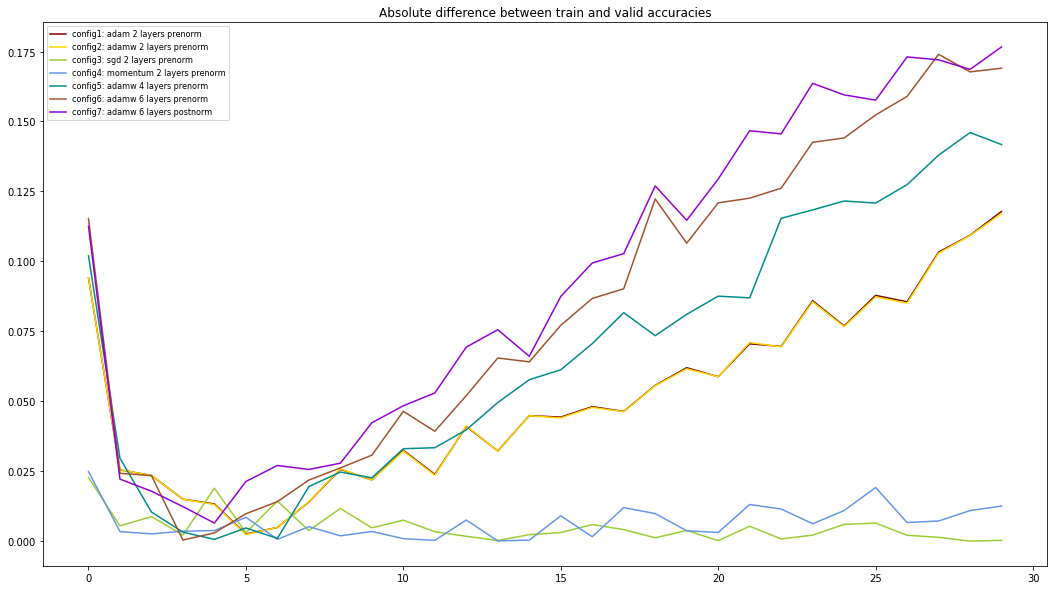

In [ ]:
plot_diff_train_valid(logs,args)

In [ ]:
t = np.array(train_accs)
v = np.array(valid_accs)

In [ ]:
(t-v).shape

(30,)